# Figure 3: Modern population t-SNE embedding

In [60]:
import pandas as pd
import skbio
import sklearn
from plotnine import *
import numpy as np
import multiprocessing
from functools import partial
from ete3 import NCBITaxa
from io import StringIO
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa as skbio_mds
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from skbio import TreeNode

In [2]:
seed=42
np.random.seed(seed)

In [27]:
modern_sources = pd.read_csv("../../data/sourcepredict/modern_gut_microbiomes_sources.csv", index_col=0)
modern_labels = pd.read_csv("../../data/sourcepredict/modern_gut_microbiomes_labels.csv", index_col=0)
source_labels = pd.read_csv("../../tables/table_s3_reference_sample_acc_list.csv", sep=";", index_col=0)

In [28]:
source_labels = source_labels.set_index(source_labels.index.str.replace(" ",""))

In [29]:
def gmpr_size_factor(col, ar):
    pr = np.apply_along_axis(lambda x: np.divide(ar[:, col], x), 0, ar)
    pr[np.isinf(pr)] = np.nan
    pr[pr == 0] = np.nan
    pr_median = np.nanmedian(pr, axis=0)
    return(np.exp(np.mean(np.log(pr_median))))

def GMPR_normalize(df, process):
    """
    Global Mean of Pairwise Ratios
    Chen, L., Reeve, J., Zhang, L., Huang, S., Wang, X., & Chen, J. (2018). 
    GMPR: A robust normalization method for zero-inflated count data 
    with application to microbiome sequencing data. 
    PeerJ, 6, e4600.
    """
    ar = np.asarray(df)

    gmpr_sf_partial = partial(gmpr_size_factor, ar=ar)
    with multiprocessing.Pool(process) as p:
        sf = p.map(gmpr_sf_partial, list(range(np.shape(ar)[1])))

    return(pd.DataFrame(np.divide(ar, sf), index=df.index, columns=df.columns))

## GMPR Normalization

In [30]:
modern_norm = GMPR_normalize(modern_sources, process=10)

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero 

### Dividing dataset intro train and test

In [31]:
training = modern_norm.sample(frac=0.8, axis = 1)

In [32]:
test = modern_norm.drop(training.columns, axis=1)

#### Panel A: Embedding of the training dataset

**Computing the distance matrix**

In [33]:
 def compute_distance(df, rank='species'):
        """
        Sample pairwise distance computation
        Args:
            - rank(str): Taxonomics rank to keep for filtering OTUs
        """

        # Getting a single Taxonomic rank
        ncbi = NCBITaxa()
        only_rank = []
        for i in list(df.index):
            try:
                if ncbi.get_rank([i])[i] == rank:
                    only_rank.append(i)
            except KeyError:
                continue
        df_rank = df.loc[only_rank, :].T
        tree = ncbi.get_topology(list(df_rank.columns), intermediate_nodes=False)
        newick = TreeNode.read(StringIO(tree.write()))
        df_wu = beta_diversity("weighted_unifrac", counts=df_rank.values.astype(int), ids=list(df_rank.index), otu_ids=[str(i) for i in list(df_rank.columns)], tree=newick)
        df_wu = df_wu.to_data_frame()
        return(df_wu)

In [34]:
training_wu_df = compute_distance(training)

**TSNE Embedding**

In [35]:
tsne = TSNE(metric='precomputed',n_components=2, random_state=seed)
train_embed = tsne.fit(np.matrix(training_wu_df))

In [36]:
train_embed = pd.DataFrame(train_embed.embedding_, columns = ['DIM1','DIM2'], index = training_wu_df.index)

In [37]:
train_embed_plot =train_embed.merge(source_labels, left_index=True, right_index=True)

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: results/figure3A.png
  warn('Filename: {}'.format(filename))


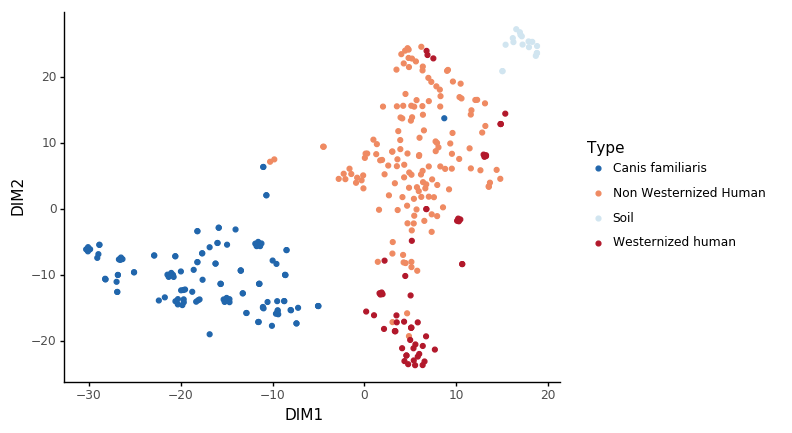

In [196]:
p = ggplot(train_embed_plot, aes(x='DIM1',y='DIM2')) + geom_point(aes(color='Type'))
p = p + scale_color_manual(values = {"Canis familiaris":"#2166ac","Non Westernized Human":"#ef8a62","Westernized human":"#b2182b", "Soil":"#d1e5f0"}) + theme_classic()
p.draw()
p.save('results/figure3A.png', dpi=300)

#### Panel B: Embedding training and test dataset, then KNN to predict test sources

In [40]:
training_labels = modern_labels.loc[training_wu_df.index,:]

**Computing the distance matrix on all data**

In [41]:
all_wu_df = compute_distance(modern_sources)

**TSNE Embedding**

In [42]:
all_embed = tsne.fit(np.matrix(all_wu_df))

In [43]:
all_embed = pd.DataFrame(all_embed.embedding_, columns = ['DIM1','DIM2'], index = all_wu_df.index)

In [44]:
all_embed.merge(modern_labels[''])

,DIM1,DIM2
SRR1175007,-5.868009,23.966011
SRR042182,-2.575737,18.508326
SRR061154,-4.845985,26.702312
SRR061499,-2.719011,21.911171
SRR063469,-4.245211,18.902060


In [46]:
all_embed.shape

(432, 2)

In [58]:
all_embed = all_embed.merge(source_labels['Type'], left_index=True, right_index=True)

#### KNN machine learning

**Splitting the train dataset in training and validation**

In [92]:
train_ds = all_embed.loc[train_embed.index,:]

In [159]:
test_ds = all_embed.drop(train_ds.index, axis=0)

In [96]:
train_features, valid_features, train_labels, valid_labels = train_test_split(train_ds.drop('Type', axis=1), 
                                                                              train_ds.loc[:, 'Type'], 
                                                                              test_size=0.2, 
                                                                              random_state=seed)

In [97]:
train_with_labels = train_features.merge(train_labels, left_index=True, right_index=True)

In [98]:
train_features, valid_calibrate_features, train_labels, valid_calibrate_labels = train_test_split(train_with_labels.drop('Type', axis=1), 
                                                                              train_with_labels.loc[:, 'Type'], 
                                                                              test_size=0.2, 
                                                                              random_state=seed)

**Cross validation search of best KNN parameters (Number of Neighbors)**

In [99]:
knn = KNeighborsClassifier(n_jobs=10)

In [100]:
param_knn_grid = {'n_neighbors': [10, 20, 50]}

In [101]:
CV_knn = GridSearchCV(estimator=knn, param_grid=param_knn_grid, cv=3, n_jobs=10)

In [102]:
CV_knn.fit(train_features, train_labels)

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=10,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=10, param_grid={'n_neighbors': [10, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

**Training the KNN classifier with best parameters**

In [103]:
knn1 = KNeighborsClassifier(n_neighbors=CV_knn.best_params_['n_neighbors'], weights='distance', n_jobs=10)

In [104]:
knn1.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=10, n_neighbors=10, p=2,
                     weights='distance')

**Prediction the validation source labels**

In [105]:
y_pred = knn1.predict(valid_features)

In [119]:
print("Validation Accuracy:", round(metrics.accuracy_score(valid_labels, y_pred), 2))

Validation Accuracy: 0.96


**Correcting Trained KNN model for Class probability estimation with Platt scaling**

In [107]:
cal_knn = CalibratedClassifierCV(knn1, cv='prefit', method='sigmoid')

In [108]:
cal_knn.fit(valid_calibrate_features, valid_calibrate_labels)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                           leaf_size=30,
                                                           metric='minkowski',
                                                           metric_params=None,
                                                           n_jobs=10,
                                                           n_neighbors=10, p=2,
                                                           weights='distance'),
                       cv='prefit', method='sigmoid')

**Predicting the labels of the test dataset**

In [150]:
test_pred = cal_knn.predict(test_ds.drop('Type', axis=1))

In [120]:
print("Test Accuracy:", round(metrics.accuracy_score(test_ds['Type'], test_pred), 2))

Test Accuracy: 0.98


In [152]:
predict_ds = test_ds.drop('Type', axis=1)

In [153]:
predict_ds['Type'] = test_pred

In [160]:
combined_test = test_ds.append(predict_ds)

In [202]:
combined_test['ml'] = ['Actual']*test_ds.shape[0]+['Predicted']*predict_ds.shape[0]

In [214]:
combined_test['ml'] = combined_test['ml'].astype('category').cat.reorder_categories(['Actual','Predicted'])

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: results/figure3B.png
  warn('Filename: {}'.format(filename))


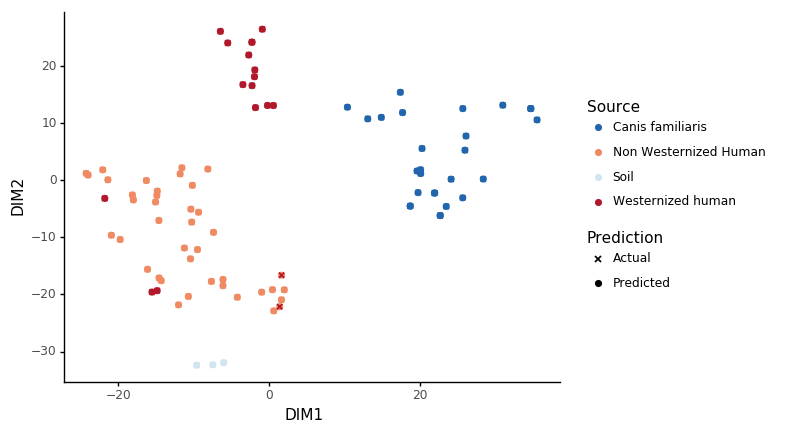

In [217]:
p = ggplot(combined_test, aes(x='DIM1',y='DIM2')) + geom_point(aes(color='Type', shape='ml'), stroke=0.7)
p = p + scale_color_manual(name='Source', values = {"Canis familiaris":"#2166ac","Non Westernized Human":"#ef8a62","Westernized human":"#b2182b", "Soil":"#d1e5f0"}) 
p = p + theme_classic() + scale_shape_manual(name = "Prediction", values={"Predicted":"o","Actual":"x"})
p.draw()
p.save('results/figure3B.png', dpi=300)